In [71]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from sherpa.astro.data import DataPHA
from sherpa.astro.io import read_pha, read_arf, read_rmf
from astropy.io import fits
import os
from sherpa.astro.plot import DataPHAPlot
import copy
from sherpa.utils.logging import SherpaVerbosity
import scipy as sci
import tensorflow as tf
import keras
from decimal import Decimal

In [70]:
# Load in all of the spectra for each observation for each detector as DataPHA objects and in the 
# process assign the response files and background (and background subtract)
obs_ids = []
spectra = {}
for source_dir in os.listdir('spectra_files'):
    source_path = os.path.join('spectra_files', source_dir)
    if os.path.isdir(source_path):
        for obsid_dir in os.listdir(source_path):
            obsid_path = os.path.join(source_path, obsid_dir)
            if os.path.isdir(obsid_path):
                obsid_trimmed = f"{obsid_path.split('/')[-2]}/{obsid_path.split('/')[-1]}"
                if obsid_trimmed != 'her_x-1/01001899': # for some reason the rmf doesn't work with this one
                    print(f'Processing {obsid_trimmed}')
                    obs_ids.append(obsid_trimmed)
                    stokes = ['I', 'Q', 'U']
                    for stoke in stokes:
                        for det in range(1, 4):
                            for reg in ['src', 'bkg']:
                                spec_hdu = fits.open(f'{obsid_path}/ixpe_det{det}_{reg}_{stoke}.pha')
                                with SherpaVerbosity("ERROR"):
                                    pha = read_pha(spec_hdu)
                                if stokes == 'I':
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.arf')
                                else:
                                    arf = read_arf(f'responses/ixpe_d{det}_20170101_alpha075_05.mrf')
                                rmf = read_rmf(f'responses/ixpe_d{det}_20170101_alpha075_02.rmf')
                                pha.set_response(arf, rmf)  
                                pha.set_analysis('energy') # convert from ixpe channels to energy
                                pha.notice(2, 8) # usable energy range in keV
                                # pha.subtract()
                                spectra[f'{obsid_trimmed}/det{det}_{stoke}_{reg}'] = pha

Processing swift_j1727/03006001
Processing swift_j1727/02251301
Processing swift_j1727/02250901
Processing swift_j1727/02251001
Processing swift_j1727/03005801
Processing swift_j1727/02251101
Processing swift_j1727/03005701
Processing swift_j1727/02251201
Processing cen_x-3/01250201
Processing cen_x-3/01006501
Processing gro_j1008-57/02003501
Processing gro_j1008-57/02003601
Processing gx_5-1/02002799
Processing gx_9+1/03003801
Processing gx_3+1/03004101
Processing v395_car/03001201
Processing gx_9+9/01002401
Processing cir_x-1/02002699
Processing lmc_x-1/02001901
Processing 4u_1735-44/03004001
Processing sco_x-1/02002401
Processing 4u_1820-303/02002399
Processing cyg_x-3/02001899
Processing cyg_x-3/02250301
Processing cyg_x-3/03250301
Processing cyg_x-3/02009101
Processing smc_x-1/02007001
Processing smc_x-1/02007101
Processing smc_x-1/02007201
Processing gx_340+0/03009901
Processing gx_340+0/03003301
Processing cyg_x-2/01001601
Processing cyg_x-2/01006601
Processing exo_2030+375/0225

In [72]:
def rebin(energy, flux, bins):
    rebinnedFlux = np.histogram(energy, bins, weights=flux)[0]/np.histogram(energy, bins)[0]
    rebinnedEnergy = (bins[:-1] + bins[1:])/2
    return rebinnedEnergy, rebinnedFlux

def SumDetectorsAndBin(obsid_path, stoke, bins):
    srcCounts = 0
    bkgCounts = 0
    exposures = 0
    for det in range(1, 4):
        src = spectra[f'{obsid_path}/det{det}_{stoke}_src']
        bkg = spectra[f'{obsid_path}/det{det}_{stoke}_bkg']
        exposure = fits.open(f'spectra_files/{obsid_path}/ixpe_det{det}_src_{stoke}.pha')[0].header['EXPOSURE']
        srcCounts += src.to_plot()[1] * exposure
        bkgCounts += bkg.to_plot()[1] * exposure
        exposures += exposure
        
    srcFlux = srcCounts/exposures 
    bkgFlux = bkgCounts/exposures
    binnedSrcEnergy, binnedSrcFlux = rebin(src.to_plot()[0], srcFlux, bins)
    binnedBkgEnergy, binnedBkgFlux = rebin(bkg.to_plot()[0], bkgFlux, bins)

    # Background subtract
    binnedFlux = binnedSrcFlux - binnedBkgFlux
    binnedEnergy = binnedSrcEnergy
    return binnedEnergy, binnedFlux

def MSE(y_true, y_pred):
    return print("MSE = " + '%.2E' % Decimal(str(np.round(tf.reduce_mean(tf.square(y_true - y_pred)), 5))))

In [5]:
intensity_data = []
for obs in obs_ids:
    stoke = 'I'
    # energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2)) # default bins of width 0.2 keV
    energy, flux = SumDetectorsAndBin(obs, stoke, np.linspace(2, 8, 33)) # 32 bins for dimensionality convenience
    intensity_data.append(flux)
intensity_data = np.array(intensity_data)
q_data = []
for obs in obs_ids:
    stoke = 'Q'
    # energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2)) # default bins of width 0.2 keV
    energy, flux = SumDetectorsAndBin(obs, stoke, np.linspace(2, 8, 33)) # 32 bins for dimensionality convenience
    q_data.append(flux)
q_data = np.array(q_data)
u_data = []
for obs in obs_ids:
    stoke = 'U'
    # energy, flux = SumDetectorsAndBin(obs, stoke, np.arange(2, 8+0.1, 0.2)) # default bins of width 0.2 keV
    energy, flux = SumDetectorsAndBin(obs, stoke, np.linspace(2, 8, 33)) # 32 bins for dimensionality convenience
    u_data.append(flux)
u_data = np.array(u_data)

In [26]:
# Normalize and rotate q and u spectra
pa = np.loadtxt('obs_PAPD.csv',delimiter=',', usecols=3)
pa = np.delete(pa, (74), axis=0) # remove the one observation that doesn't work (01001899)
pa = np.radians(pa)
pa_arr = np.tile(pa.transpose(), (32, 1)).transpose()
q_data_rn = (q_data * np.cos(2*pa_arr) + u_data * np.sin(2*pa_arr))/intensity_data
u_data_rn = (q_data * np.sin(2*pa_arr) - u_data * np.cos(2*pa_arr))/intensity_data

In [74]:
# Make training data by altering the q and u data with random scaling and noise
rng = np.random.default_rng(12345)
indices = rng.permutation(q_data_rn.shape[0])
training_idx, test_idx = indices[20:], indices[:20]
q_training_data, q_test_data = q_data_rn[training_idx,:], q_data_rn[test_idx,:]
q_data_aug = q_training_data.tolist()
l = len(q_data_aug)
q_test_max_vals = []
for j in range(100):
    for i in range(l):
        scale = rng.uniform(0.75, 1.25)
        noise = rng.normal(0, 0.01 * np.max(np.abs(q_training_data[i])), len(q_training_data[0]))
        q_data_aug.append(scale * q_training_data[i] + noise)
q_data_aug = np.array(q_data_aug)
# for j in range(len(q_data_aug)):
#     q_data_aug[j] = q_data_aug[j] / np.max(q_data_aug[j])
for k in range(indices.shape[0]):
    q_test_max_vals.append(np.max(np.abs(q_data_rn[indices[k]])))
u_training_data, u_test_data = u_data_rn[training_idx,:], u_data_rn[test_idx,:]
u_data_aug = u_training_data.tolist()
l = len(u_data_aug)
u_test_max_vals = []
for j in range(100):
    for i in range(l):
        scale = rng.uniform(0.75, 1.25)
        noise = rng.normal(0, 0.01 * np.max(np.abs(u_training_data[i])), len(u_training_data[0]))
        u_data_aug.append(scale * u_training_data[i] + noise)
u_data_aug = np.array(u_data_aug)
# for j in range(len(q_data_aug)):
#     q_data_aug[j] = q_data_aug[j] / np.max(q_data_aug[j])
for k in range(indices.shape[0]):
    u_test_max_vals.append(np.max(np.abs(u_data_rn[indices[k]])))

In [27]:
input = []
for i in range(len(intensity_data) ):
    input.append([intensity_data[i]])
input = np.array(input)
input = np.swapaxes(input, 1, 2)
input.shape

(79, 32, 1)

In [ ]:
# q_data_aug = []
# q_max_vals = []
# rng = np.random.default_rng()
# for j in range(100):
#     for i in range(len(obs_ids)):
#         scale = rng.uniform(0.5, 1.5)
#         noise = rng.normal(0, 0.01 * np.max(np.abs(q_data_rn[i])), len(q_data_rn[0]))
#         q_data_aug.append(scale * q_data_rn[i] + noise)
# q_data_aug = np.array(q_data_aug)
# for j in range(len(q_data_aug)):
#     q_data_aug[j] = q_data_aug[j] / np.max(np.abs(q_data_aug[j]))
#     q_max_vals.append(np.max(q_data_aug[j]))
# u_data_aug = []
# u_max_vals = []
# rng = np.random.default_rng()
# for j in range(100):
#     for i in range(len(obs_ids)):
#         scale = rng.uniform(0.5, 1.5)
#         noise = rng.normal(0, 0.01 * np.max(np.abs(u_data_rn[i])), len(u_data_rn[0]))
#         u_data_aug.append(scale * u_data_rn[i] + noise)
# u_data_aug = np.array(u_data_aug)
# for j in range(len(u_data_aug)):
#     u_data_aug[j] = u_data_aug[j] / np.max(np.abs(u_data_aug[j]))
#     u_max_vals.append(np.max(u_data_aug[j]))

In [75]:
# Build encoder using Keras Layers API
num_filters = 8
input = keras.Input(shape=input[0].shape)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
encoded0 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(x)

x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(encoded0)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
x = keras.layers.Conv1D(filters=num_filters, kernel_size=3, activation='sigmoid', padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling1D(size=2)(x)
decoded0 = keras.layers.Conv1D(filters=1, kernel_size=3, activation="sigmoid", padding="same")(x)

autoencoder0 = keras.Model(input, decoded0)
autoencoder0.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [76]:
# Visualize the model architecture
autoencoder0.summary() # print summary of model architecture

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 32, 8)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (None, 16, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 16, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (None, 8, 8)           │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_10 (UpSampling1D) │ (None, 16, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 16, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 8)          │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_11 (UpSampling1D) │ (None, 32, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 32, 1)          │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 721 (2.82 KB)

 Non-trainable params: 64 (256.00 B)

In [77]:
# Train the model
autoencoder0.fit(q_data_aug, q_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(q_test_data, q_test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3186 - val_loss: 0.3104
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2095 - val_loss: 0.2277
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 - val_loss: 0.2040
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1145 - val_loss: 0.1986
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0909 - val_loss: 0.1967
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0817 - val_loss: 0.1936
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0709 - val_loss: 0.1916
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0666 - val_loss: 0.1911
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 - val_loss: 0.1890
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0669 - val_loss: 0.1926
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0664 - val_loss: 0.1977
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0651 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


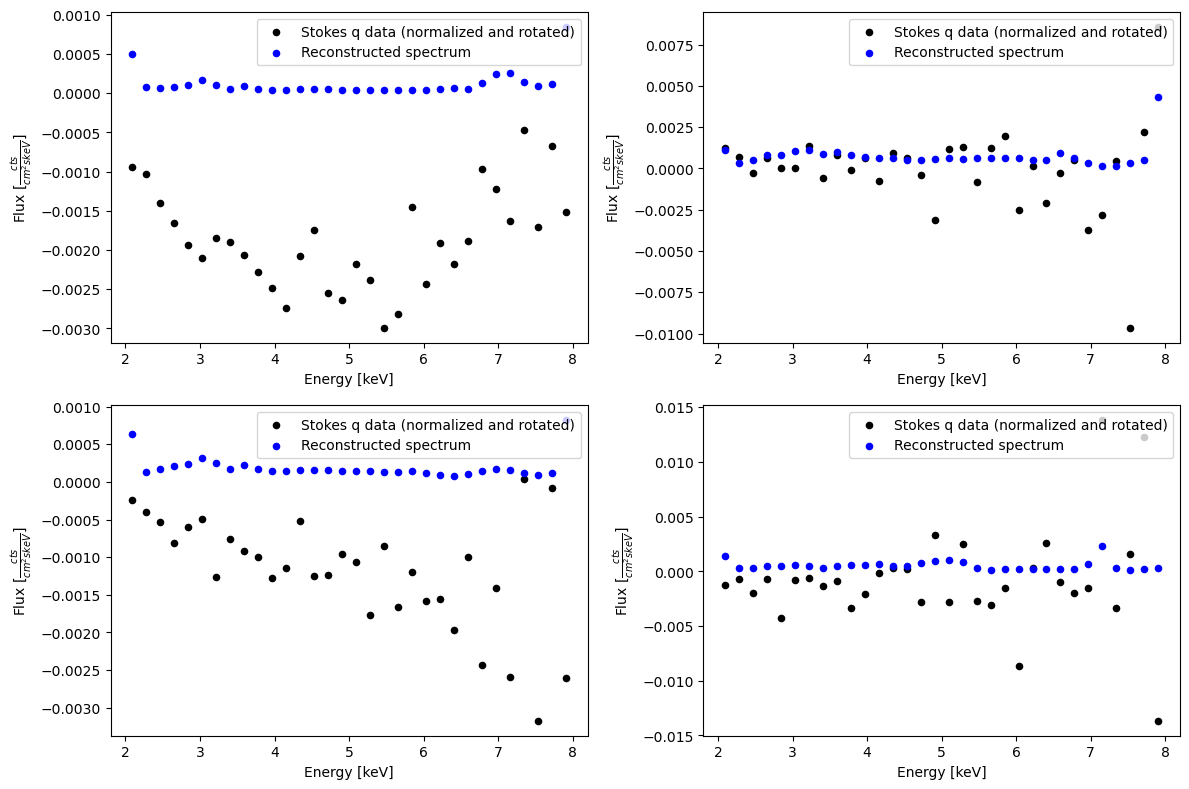

In [79]:
# Visualize the reconstructed spectra
predictions0 = autoencoder0.predict(q_test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, q_test_max_vals[samples[i]] * q_test_data[samples[i]], s=20, c='black', label = 'Stokes q data (normalized and rotated)')
    ax.scatter(midpts, q_test_max_vals[samples[i]] * predictions0[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
plt.show()

In [80]:
autoencoder1 = keras.Model(input, decoded0)
autoencoder1.compile(optimizer='adam', loss='mean_squared_error') # default: autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [81]:
# Train the model
autoencoder1.fit(u_data_aug, u_data_aug, epochs=50, batch_size=100, shuffle=True, validation_data=(u_test_data, u_test_data))

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1016 - val_loss: 0.0073
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0884 - val_loss: 0.0090
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0924 - val_loss: 0.0092
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1018 - val_loss: 0.0092
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0933 - val_loss: 0.0092
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - val_loss: 0.0093
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0941 - val_loss: 0.0093
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0937 - val_loss: 0.0092
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0894 - val_loss: 0.0093
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0890 - val_loss: 0.0095
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0951 - val_loss: 0.0093
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0999 - val_lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


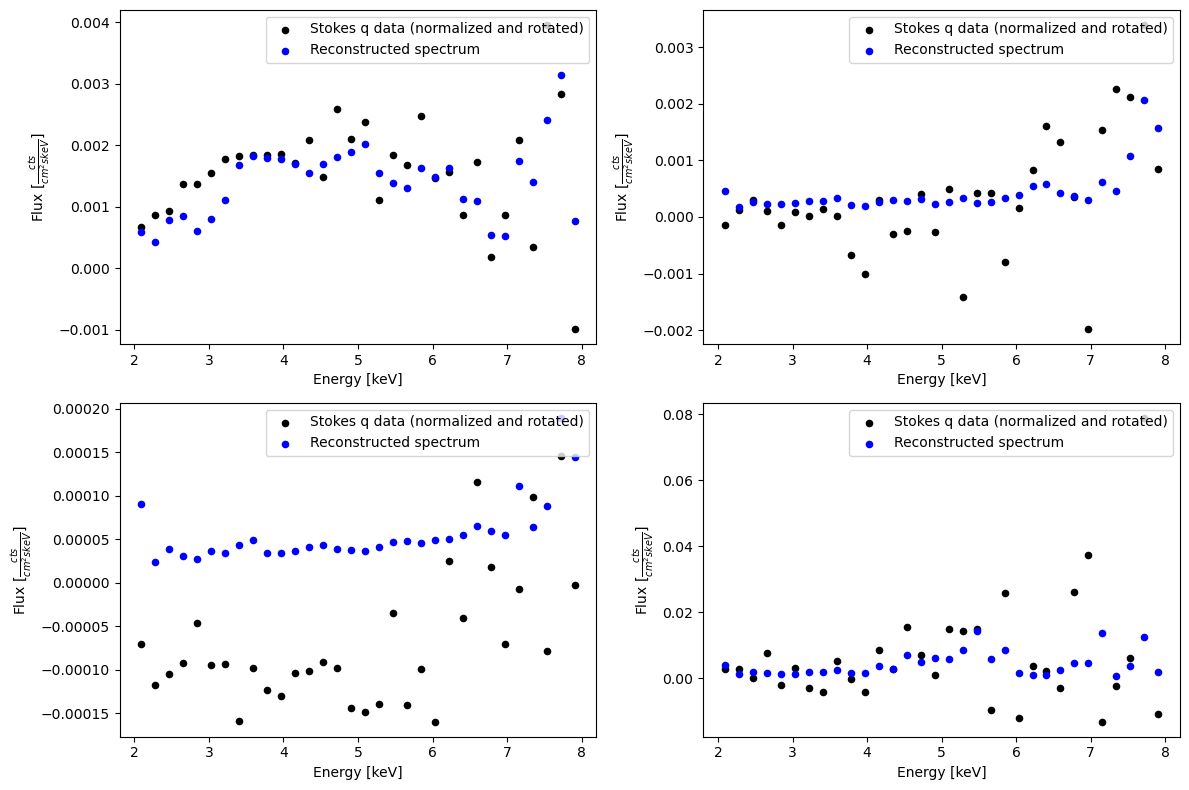

In [82]:
# Visualize the reconstructed spectra
predictions1 = autoencoder1.predict(u_test_data)
samples = [0, 4, 14, 19]
plt.figure(figsize=(12, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, u_test_max_vals[samples[i]] * u_test_data[samples[i]], s=20, c='black', label = 'Stokes q data (normalized and rotated)')
    ax.scatter(midpts, u_test_max_vals[samples[i]] * predictions1[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


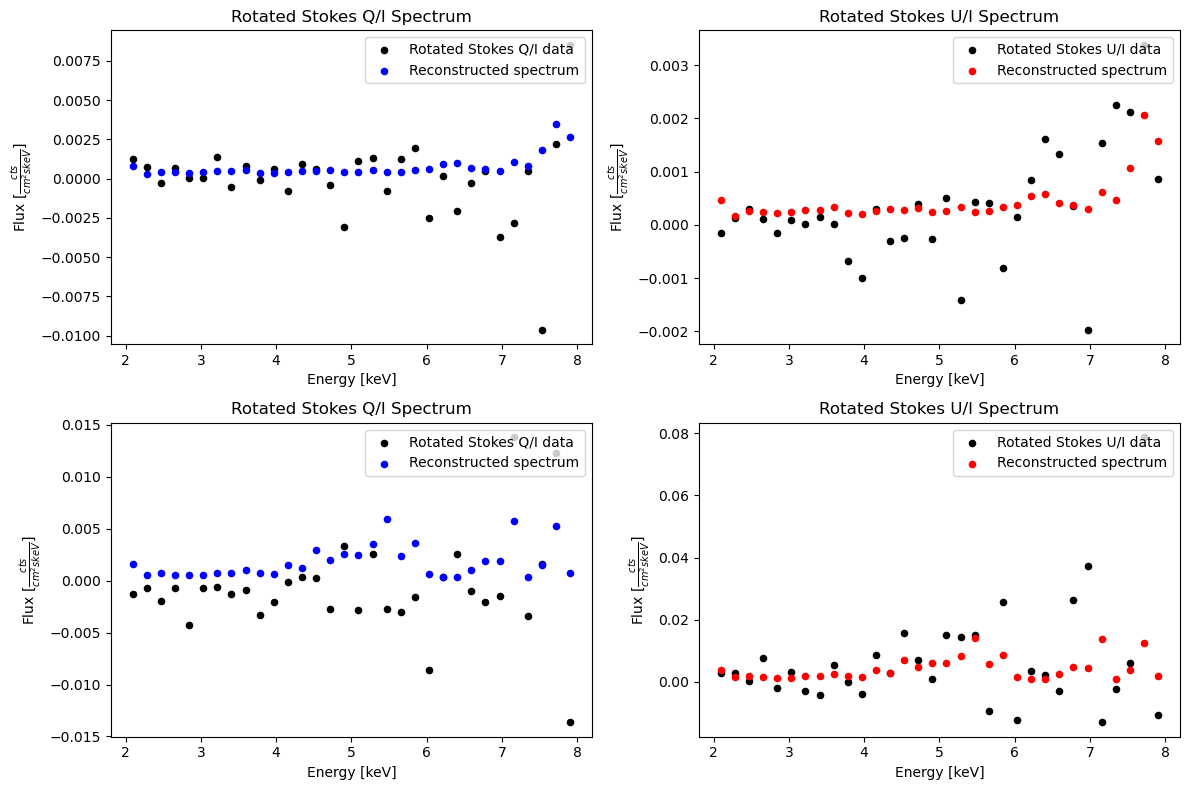

In [ ]:
# Visualize the reconstructed spectra
predictions1 = autoencoder1.predict(u_test_data)
samples = [4, 19]
plt.figure(figsize=(12, 8))
for i in range(2):
    ax = plt.subplot(2, 2, (2*i)+2)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, u_test_max_vals[samples[i]] * u_test_data[samples[i]], s=20, c='black', label = 'Rotated Stokes U/I data')
    ax.scatter(midpts, u_test_max_vals[samples[i]] * predictions1[samples[i]], s=20, c='red', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    # ax.set_title(rf'{obs_ids[samples[i]]} Rotated Stokes U/I Spectrum')
    ax.set_title('Rotated Stokes U/I Spectrum')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
for i in range(2):
    ax = plt.subplot(2, 2, (2*i)+1)
    bins = np.linspace(2, 8, 33)
    midpts = (bins[:-1] + bins[1:])/2
    ax.scatter(midpts, q_test_max_vals[samples[i]] * q_test_data[samples[i]], s=20, c='black', label = 'Rotated Stokes Q/I data')
    ax.scatter(midpts, q_test_max_vals[samples[i]] * predictions1[samples[i]], s=20, c='blue', label = 'Reconstructed spectrum')
    ax.legend(loc='upper right')
    ax.set_xlabel('Energy [keV]')
    # ax.set_title(rf'{obs_ids[samples[i]]} Rotated Stokes Q/I Spectrum')
    ax.set_title('Rotated Stokes Q/I Spectrum')
    ax.set_ylabel(r'Flux $[\frac{cts}{cm^2 s keV}]$')
    # ax.set_title(rf'{obs} ${stoke}$ Stokes spectrum averaged over detectors and rebinned')
plt.tight_layout()
# plt.savefig('qu_reconstruction_8x8.png', bbox_inches='tight', dpi=200)
plt.show()